This tutorial can be downloaded [link](https://github.com/west-code-development/West/raw/master/Doc/tutorials/basic/basic_008.ipynb).

# Intro Tutorial 8: Using the Finite-Field (FF) Approach to Perform GW and BSE Calculations

This tutorial shows how to couple the WEST and [Qbox](http://qboxcode.org/) codes in the so-called client server mode to carry out GW and BSE calculations, within or beyond the random phase approximation (RPA), using finite-field (FF) approaches as reported in [Ma et al., J. Chem. Theory Comput. 15, 154-164 (2019)](https://doi.org/10.1021/acs.jctc.8b00864) and [Nguyen et al., Phys. Rev. Lett. 122, 237402 (2019)](https://doi.org/10.1103/PhysRevLett.122.237402).

## Step 1:  Mean-field starting point

### Step 1.1: Mean-field calculation using Quantum ESPRESSO

We first perform the mean-field electronic structure calculation within DFT using the [Quantum ESPRESSO](https://www.quantum-espresso.org/) code.

Download the following files to your working directory:

In [1]:
%%bash
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/C_ONCV_PBE-1.2.upf
wget -N -q https://west-code.org/doc/training/C60/pw.in
wget -N -q https://west-code.org/doc/training/C60/nscf.in

We can inspect the `pw.in` file, the input for the `pw.x` code:

In [2]:
%%bash
cat pw.in

&control
pseudo_dir = './'
calculation = 'scf'
wf_collect = .TRUE.
/
&system
ibrav = 0
ntyp = 1
nat = 60
ecutwfc = 20
/
&electrons
diago_full_acc = .TRUE.
/
ATOMIC_SPECIES
C 14 C_ONCV_PBE-1.2.upf
ATOMIC_POSITIONS bohr
C  6.560216999227  1.317708999068  0.000000000000
C  5.716322000011  2.686502999941 -2.213027000418
C  6.560216999227 -1.317708999068  0.000000000000
C  4.900061000384  1.363055000501 -4.347289999376
C  2.686503999607  2.213028000083 -5.716321000346
C  4.347291000932  4.900060000718 -1.363055000501
C  2.213028000083  5.716322000011 -2.686502000276
C  1.363056000166  4.347291000932 -4.900058999163
C  4.900058999163 -1.363055000501  4.347289999376
C  4.900058999163  1.363055000501  4.347289999376
C  5.716321000346 -2.686502999941  2.213027000418
C  5.716321000346  2.686502999941  2.213027000418
C  4.347291000932  4.900060000718  1.363055000501
C  2.686501000610  2.213028000083  5.716321000346
C  1.363054000835  4.347291000932  4.900058999163
C  2.213027000418  5.71632200001

We run `pw.x` on 32 cores.

In [ ]:
%%bash
mpirun -n 32 pw.x -i pw.in > pw.out

To include a few unoccupied bands (in this case 800 bands in total) we run a non-self-consistent calculation. The content of `nscf.in` is almost identical to that of `pw.in`, except that in `nscf.in` we request a non-self-consistent calculation with empty bands.

We run `pw.x` again on 32 cores.

In [ ]:
%%bash
mpirun -n 32 pw.x -i nscf.in > nscf.out

### Step 1.2: Mean-field calculation using Qbox

Next we repeat the mean-field electronic structure calculation using the [Qbox](http://qboxcode.org/) code.

Download the following files to your working directory:

In [3]:
%%bash
wget -N -q https://west-code.org/doc/training/C60/qb.in
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/xml/C_ONCV_PBE-1.2.xml

We can inspect the `qb.in` file, the input for the `qb` code:

In [4]:
%%bash
cat qb.in

set cell 30.0 0.0 0.0  0.0 30.0 0.0  0.0 0.0 30.0
species carbon C_ONCV_PBE-1.2.xml
atom C1 carbon  6.560216999227  1.317708999068  0.000000000000
atom C2 carbon  5.716322000011  2.686502999941 -2.213027000418
atom C3 carbon  6.560216999227 -1.317708999068  0.000000000000
atom C4 carbon  4.900061000384  1.363055000501 -4.347289999376
atom C5 carbon  2.686503999607  2.213028000083 -5.716321000346
atom C6 carbon  4.347291000932  4.900060000718 -1.363055000501
atom C7 carbon  2.213028000083  5.716322000011 -2.686502000276
atom C8 carbon  1.363056000166  4.347291000932 -4.900058999163
atom C9 carbon  4.900058999163 -1.363055000501  4.347289999376
atom C10 carbon  4.900058999163  1.363055000501  4.347289999376
atom C11 carbon  5.716321000346 -2.686502999941  2.213027000418
atom C12 carbon  5.716321000346  2.686502999941  2.213027000418
atom C13 carbon  4.347291000932  4.900060000718  1.363055000501
atom C14 carbon  2.686501000610  2.213028000083  5.716321000346
atom C15 carbon  1.3630540008

We use the same atomic positions, exchange-correlation functional, cutoff energy, and pseudopotential for `qb` as used for `pw.x` in the previous step. Check out the [Qbox documentation](http://qboxcode.org/doc/html/) for more information about how to operate the code.

We run `qb` on 32 cores.

In [ ]:
%%bash
mpirun -n 32 qb < qb.in > qb.out

The information of the ground state calculation, including the Kohn-Sham wavefunctions, is stored in the file `qb.gs.xml`. To accelerate the BSE calculation, we localize the ground state wavefunctions using the recursive subspace bisection technique implemented in Qbox. Download the input file to your working directory:

In [5]:
%%bash
wget -N -q https://west-code.org/doc/training/C60/qb2.in

We can inspect the `qb2.in` file:

In [6]:
%%bash
cat qb2.in

load qb.gs.xml

bisection 5 5 5 0.0316
save qb.bis.0.0316.xml

set xc HF
set btHF 0.0316
set blHF 5 5 5

set wf_dyn LOCKED

run 0


We run `qb` again on 32 cores.

In [ ]:
%%bash
mpirun -n 32 qb < qb2.in > qb2.out

`qb` will localize the wavefunctions stored in `qb.gs.xml`, then write the localized wavefunctions to the file `qb.bis.0.0316.xml`. We use the [WESTpy Python package](https://west-code.org/doc/westpy/latest/) to parse the Qbox output files.

In [ ]:
from westpy.bse import *

qb = Qbox2BSE("qb2.out")
qb.write_localization()
qb.write_wavefunction()

This generates two files, namely `bis_info.1` containing bisection localization information and `qb_wfc.1` containing localized wavefunctions in the HDF5 format. The extension, `.1`, denotes the spin channel. Both files will be used in the BSE calculation.

## Step 2: GW calculation

### Step 2.1: Calculation of dielectric screening using WEST-Qbox coupling

We compute the static dielectric screening using the `wstat.x` executable. Download the following file to your working directory:

In [7]:
%%bash
wget -N -q https://west-code.org/doc/training/C60/wstat.in

Let us inspect the `wstat.in` file:

In [8]:
%%bash
cat wstat.in

input_west:
  outdir: ./

wstat_control:
  wstat_calculation: SE
  n_pdep_eigen: 720

server_control:
  document: {"response": {"amplitude": 0.001, "nitscf": 50, "nite": 5, "approximation": RPA}, "script": ["load ./qb.gs.xml \n set xc PBE \n"]}


The `wstat_calculation: SE` keyword means **S**tart from scratch and **E**xternal, i.e., the calculation is outsourced to Qbox. The `document` keyword contains the specifics of running WEST and Qbox in the client-server mode. In this mode, we run `wstat.x` together with multiple instances of `qb`. To evaluate density response functions, the client, `wstat.x`, dispatches finite field calculations to the server, `qb`. Each instance of `qb` computes the density response to the finite electric field. The same calculation can be done without resorting to the RPA, simply by taking out the `"approximation": RPA` part from `document`.

![Image of client_server](https://pubs.acs.org/cms/10.1021/acs.jctc.8b00864/asset/images/medium/ct-2018-00864q_0008.gif)

An example script to run such a calculation looks as follows:

In [ ]:
%%bash
nimages=8

# Submit nimages instances of Qbox (each instance runs on 32 cores)

for (( i=0; i<$nimages; i++ ))
do
    qb_in=`printf "qb.%d.in" $i`
    qb_out=`printf "qb.%d.out" $i`
    mpirun -n 32 ./qb -server $qb_in $qb_out &
    sleep 1
done

# Submit 1 instance of WEST (it runs on 32 cores)
mpirun -n 32 ./wstat.x -ni $nimages -i wstat.in > wstat.out &
wait

The user must request computational resources for `wstat.x` and all instances of `qb`. In this example, we run `wstat.x` with eight instances of `qb`, requesting $32 \times (1+8) = 288$ cores.

### Step 2.2: Calculation of quasiparticle corrections using WEST

Now we run the `wfreq.x` executable to compute the quasiparticle corrections. Download the following file to your working directory:

In [9]:
%%bash
wget -N -q https://west-code.org/doc/training/C60/wfreq.in

Let us inspect the `wfreq.in` file:

In [10]:
%%bash
cat wfreq.in

input_west:
  outdir: ./

wstat_control:
  wstat_calculation: SE
  n_pdep_eigen: 720

server_control:
  document: {"response": {"amplitude": 0.001, "nitscf": 50, "nite": 5, "approximation": RPA}, "script": ["load ./qb.gs.xml \n set xc PBE \n"]}

wfreq_control:
  wfreq_calculation: XWGQ
  n_pdep_eigen_to_use: 720
  qp_bandrange: [101,140]


In the `wfreq_control` section, there are no input keywords specific to the FF method.

We run `wfreq.x` on 512 cores:

In [ ]:
%%bash
mpirun -n 512 ./wfreq.x -ni 16 -i wfreq.in > wfreq.out

The reader is encouraged to repeat Step 2 using the PDEP method and compare the quasiparticle energies.

## Step 3: BSE calculation

### Step 3.1: BSE initialization using WEST-Qbox coupling

We perform an initialization step to compute the screened exchange integrals using the `wbse_init.x` executable. Download the following file to your working directory:

In [11]:
%%bash
wget -N -q https://west-code.org/doc/training/C60/wbse_init.in

Let us inspect the `wbse_init.in` file:

In [12]:
%%bash
cat wbse_init.in

input_west:
  outdir: ./

wbse_init_control:
  wbse_init_calculation: S
  bse_method: FF_Qbox
  localization: B

server_control:
  document: {"response": {"amplitude": 0, "nitscf": 20, "nite": 0}, "script": ["load ./qb.gs.xml \n set xc PBE \n set wf_dyn PSDA \n set blHF 2 2 2 \n set btHF 0.00 \n"]}


The `bse_method: FF_Qbox` keyword selects the FF method to solve the BSE. The `localization: B` keyword instructs the code to use wavefunctions localized by the recursive subspace bisection method implemented in Qbox. If two localized wavefunctions do not overlap with each other, the evaluation of the corresponding screened exchange integral is skipped, thus reducing the computational cost. Localized wavefunctions and bisection information are read from files `bis_info.1` and `qb_wfc.1` obtained in Step 1.2.

The `document` keyword is used to run WEST and Qbox in the client-server mode. But as opposed to Step 2.1, `"approximation": RPA` is not specified, allowing for a calculation beyond the RPA. An example script to run this calculation looks as follows:

In [ ]:
%%bash
nimages=8

# Submit nimages instances of Qbox (each instance runs on 32 cores)

for (( i=0; i<$nimages; i++ ))
do
    qb_in=`printf "qb.%d.in" $i`
    qb_out=`printf "qb.%d.out" $i`
    mpirun -n 32 ./qb -server $qb_in $qb_out &
    sleep 1
done

# Submit 1 instance of WEST (it runs on 32 cores)
mpirun -n 32 ./wbse_init.x -ni $nimages -i wbse_init.in > wbse_init.out &
wait

Again, the user must request computational resources for `wbse_init.x` and all instances of `qb`.

### Step 3.2: BSE absorption spectrum using WEST

Now we run the `wbse.x` executable to compute the absorption spectrum of C60. Download the following file to your working directory:

In [13]:
%%bash
wget -N -q https://west-code.org/doc/training/C60/wbse.in

Let us inspect the `wbse.in` file:

In [14]:
%%bash
cat wbse.in

input_west:
  outdir: ./

wbse_init_control:
  wbse_init_calculation: S
  bse_method: FF_Qbox
  localization: B

server_control:
  document: {"response": {"amplitude": 0, "nitscf": 20, "nite": 0}, "script": ["load ./qb.gs.xml \n set xc PBE \n set wf_dyn PSDA \n set blHF 2 2 2 \n set btHF 0.00 \n"]}

wbse_control:
  wbse_calculation: L
  qp_correction: west.wfreq.save/wfreq.json
  wbse_ipol: XYZ
  n_lanczos: 1300


In the `wbse_control` section, there are no input keywords specific to the FF method.

We run `wbse.x` on 512 cores:

In [ ]:
%%bash
mpirun -n 512 ./wbse.x -ni 16 -i wbse.in > wbse.out

The output can be found in the file `west.wbse.save/wbse.json`. If the reader does NOT have the computational resources to run the calculations, the output file can be directly downloaded as:

In [15]:
%%bash
mkdir -p west.wbse.save
wget -N -q https://west-code.org/doc/training/C60/wbse.json -O west.wbse.save/wbse.json

We use WESTpy to parse this file and plot the absorption coefficient as a function of the photon frequency.

 
 _    _ _____ _____ _____            
| |  | |  ___/  ___|_   _|           
| |  | | |__ \ `--.  | |_ __  _   _  
| |/\| |  __| `--. \ | | '_ \| | | | 
\  /\  / |___/\__/ / | | |_) | |_| | 
 \/  \/\____/\____/  \_/ .__/ \__, | 
                       | |     __/ | 
                       |_|    |___/  
 
WEST version     :  5.2.0
Today            :  2023-02-23 14:55:04.600349
output written in :  chi_XYZ.png
waiting for user to close image preview...


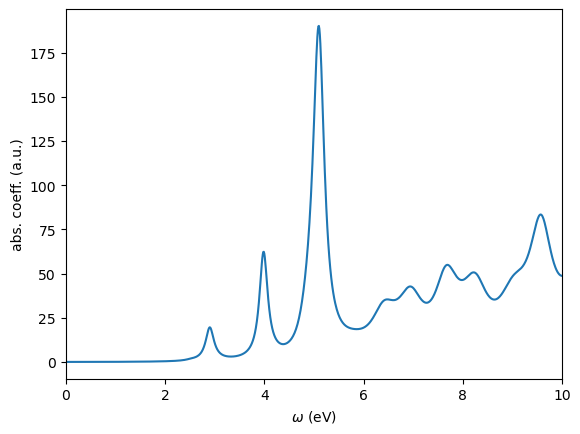

In [16]:
from westpy.bse import *

wbse = BSEResult("west.wbse.save/wbse.json")
wbse.plotSpectrum(ipol="XYZ",energyRange=[0.0,10.0,0.01],sigma=0.1,n_extra=98700)

It can be verified that the FF method used in this tutorial and the PDEP method used in [Tutorial 7](https://github.com/west-code-development/West/raw/master/Doc/tutorials/basic/basic_007.ipynb) yield virtually identical absorption spectra.